In [4]:

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from river import anomaly

# Chargement des données
data = pd.read_csv("C:\\Users\\michael\\Downloads\\MetroPT3(AirCompressor).csv")
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

In [5]:
# Normalisation des colonnes analogiques
analog_cols = ['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Motor_current', 'Oil_temperature']
scaler = MinMaxScaler()
data[analog_cols] = scaler.fit_transform(data[analog_cols])

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

# Modèle IsolationForest

# Divisons les données en train set et test set (par exemple 80% pour l'entraînement et 20% pour le test)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Créons le modèle IsolationForest
model_batch = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)

# Entraînons le modèle sur les données d'entraînement
model_batch.fit(train_data)

# Prédisons les anomalies sur l'ensemble de test
anomalies_test = model_batch.predict(test_data)

# Ajoutons les résultats de détection des anomalies dans le test set
test_data['anomaly_batch'] = anomalies_test


In [7]:
# Modèle HalfSpaceTrees

model_stream = anomaly.HalfSpaceTrees(n_trees=5, height=10, window_size=100, seed=42)
anomalies_stream = []

for idx, row in data.iterrows():
    model_stream.learn_one(row.to_dict())
    score = model_stream.score_one(row.to_dict())
    anomalies_stream.append(1 if score < 0.5 else -1)  # Seuil personnalisé

data['anomaly_stream'] = anomalies_stream

C:\Users\michael\AppData\Local\Temp\ipykernel_21984\654706098.py:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\michael\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


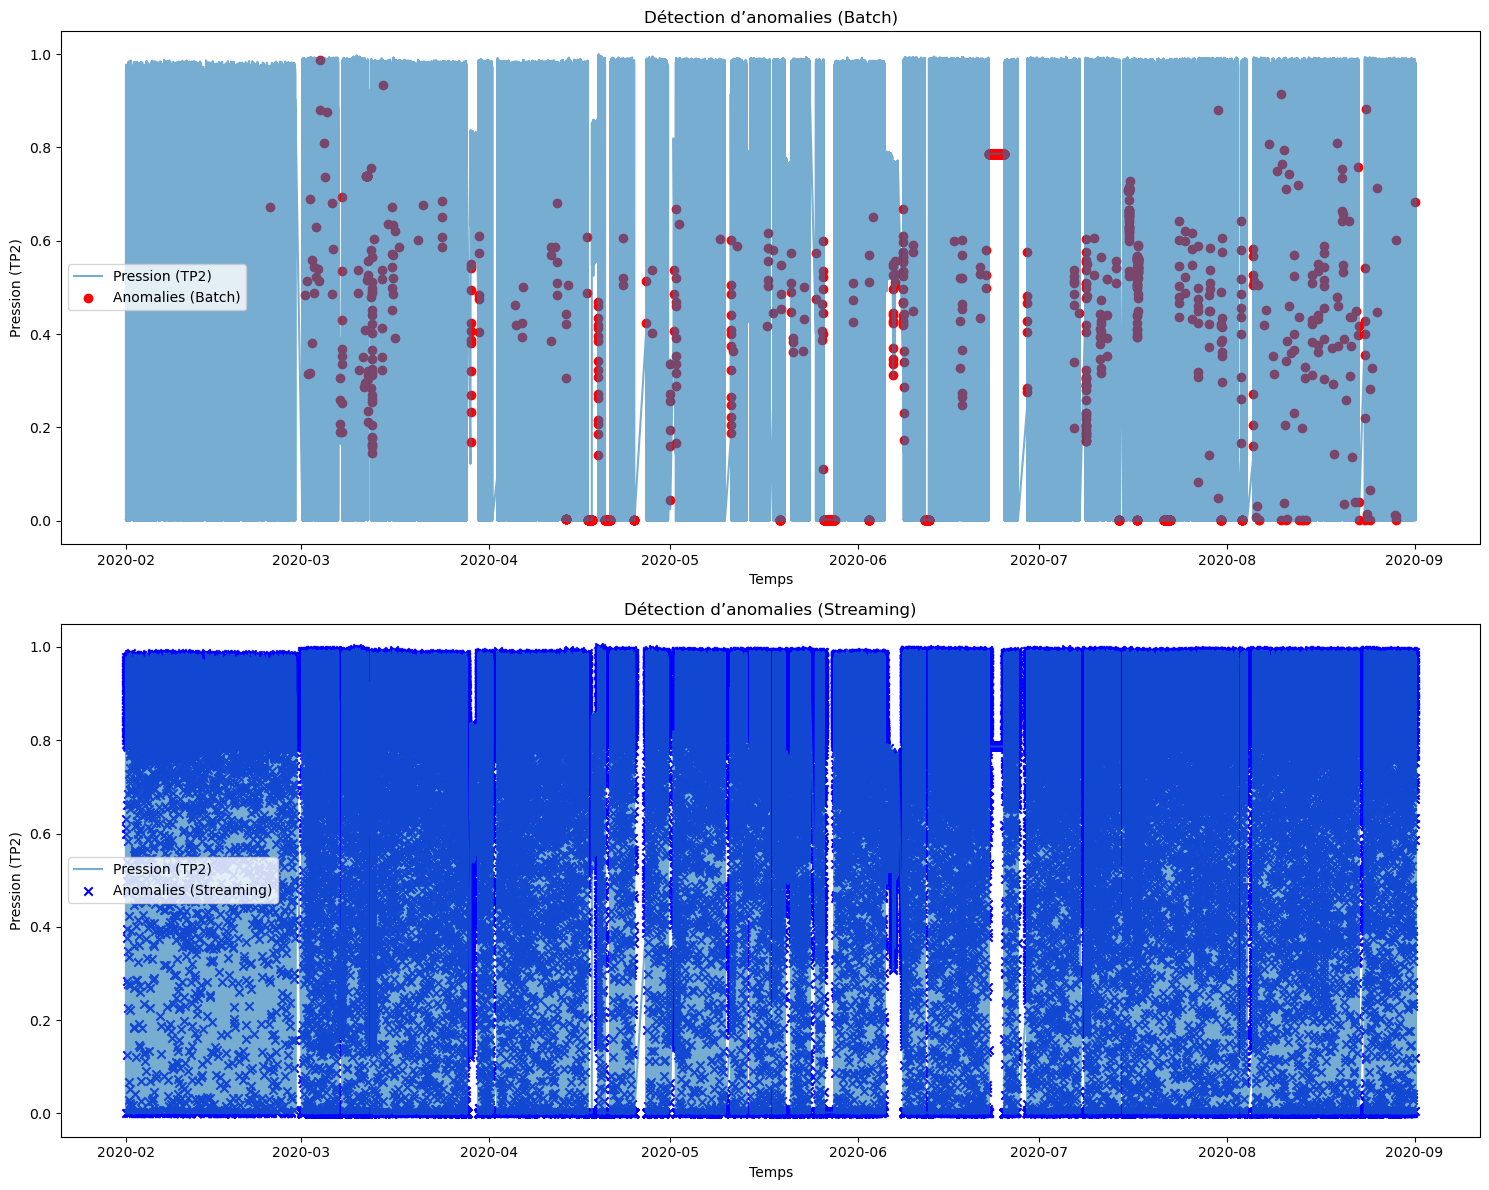

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Ajoutons les prédictions d'anomalies du test set à l'ensemble complet
data['anomaly_batch'] = np.nan
data.loc[test_data.index, 'anomaly_batch'] = test_data['anomaly_batch']

# Créons la figure et les sous-graphiques
fig, ax = plt.subplots(2, 1, figsize=(15, 12))  # Deux graphiques superposés

# Premier graphique : Pression TP2 et anomalies Batch
ax[0].plot(data.index, data['TP2'], label='Pression (TP2)', alpha=0.6)
ax[0].scatter(data[data['anomaly_batch'] == -1].index, 
              data[data['anomaly_batch'] == -1]['TP2'], 
              color='red', label='Anomalies (Batch)')
ax[0].set_xlabel('Temps')
ax[0].set_ylabel('Pression (TP2)')
ax[0].set_title('Détection d’anomalies (Batch)')
ax[0].legend()

# Deuxième graphique : Anomalies Streaming
ax[1].plot(data.index, data['TP2'], label='Pression (TP2)', alpha=0.6)
ax[1].scatter(data[data['anomaly_stream'] == -1].index, 
              data[data['anomaly_stream'] == -1]['TP2'], 
              color='blue', marker='x', label='Anomalies (Streaming)')
ax[1].set_xlabel('Temps')
ax[1].set_ylabel('Pression (TP2)')
ax[1].set_title('Détection d’anomalies (Streaming)')
ax[1].legend()

# Affichons les graphiques
plt.tight_layout()
plt.show()
